# Hackathon - Particle Images
## Problem Statement
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice.



## Create the appropriate project folder

# Import modules

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [2]:
lr_init     = 1.e-3    # Initial learning rate
batch_size  = 256       # Training batch size
train_size  = 1024*25     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [5]:
img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = './Particle_Images/data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [6]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train2, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid2, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

<ipython-input-5-30df6f3ea728>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]


In [7]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

<ipython-input-5-30df6f3ea728>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]


# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

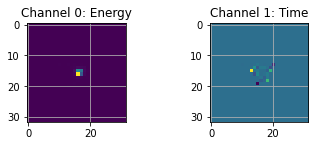

In [8]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [9]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dense, Flatten
from keras.models import Model

# 입력 이미지의 크기
input_shape = (32, 32, 2)

# 인코더(Encoder) 구성
input_img = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
encoded = Dense(3, activation='relu')(x)

# 디코더(Decoder) 구성
x = Dense(128, activation='relu')(encoded)
x = Dense(128, activation='relu')(x)
x = Dense(8*8*8, activation='relu')(x)
x = Reshape((8, 8, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

# 오토인코더(Autoencoder) 모델 생성
autoencoder = Model(input_img, decoded)

# 오토인코더 컴파일
autoencoder.compile(optimizer='adam', loss='MeanSquaredError')

# 모델 요약 정보 출력
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=autoencoder.fit(X_train, X_train2,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, X_valid2),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
200/200 [==============================] - 6s 11ms/step - loss: 0.0250 - val_loss: 0.0025 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 2.0000e-04
Epoch 5/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 2.0000e-04
Epoch 6/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 4.0000e-05
Epoch 7/20
200/200 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 4.0000e-05
Epoch 8/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0026 - val_loss: 0.0025 - lr: 8.0000e-06
Epoch 9/20
200/200 [==============================] - 2s 9ms/step - loss: 0

In [27]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_1').output)

In [29]:
encoder(X_train[:2048])[:100]

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 0.       , 17.505453 ,  6.419409 ],
       [ 0.       , 15.266569 ,  5.7462068],
       [ 0.       , 17.28466  ,  6.396924 ],
       [ 0.       , 17.16828  ,  6.495934 ],
       [ 0.       , 19.983389 ,  7.433075 ],
       [ 0.       , 15.809297 ,  6.0559826],
       [ 0.       , 13.5938425,  5.1812778],
       [ 0.       , 16.977541 ,  6.5085897],
       [ 0.       , 19.36741  ,  7.3009763],
       [ 0.       , 18.824774 ,  7.1276116],
       [ 0.       , 16.065577 ,  6.17722  ],
       [ 0.       , 15.134415 ,  5.624387 ],
       [ 0.       , 24.241083 ,  8.847046 ],
       [ 0.       , 14.572822 ,  5.510445 ],
       [ 0.       , 18.226648 ,  6.736065 ],
       [ 0.       , 16.405416 ,  6.2932553],
       [ 0.       , 16.95407  ,  6.456084 ],
       [ 0.       , 15.631613 ,  5.9847026],
       [ 0.       , 16.193857 ,  6.0758514],
       [ 0.       , 17.158205 ,  6.4390526],
       [ 0.       , 17.599705 ,  6.4930024],
     